In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv("/content/drive/MyDrive/SPR/Group07/NLS_Group07.txt",sep=" ",header=None)
df=df[1:]
df=df.iloc[:,:2]
df = df.apply(pd.to_numeric, errors='coerce')
df.head()

0         1
1  0.194597  0.479090
2  0.136626  0.540135
3  1.155159  0.982728
4  1.710516  1.021271
5  1.943185  0.487639

In [4]:
df1 = df[:500]
df2 = df[500:1000]
df3 = df[1000:]

In [5]:
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)
df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True)
df3 = df3.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
df1_train = df1[:int(len(df1)*0.7)]
df1_test = df1[int(len(df1)*0.7):]
df2_train = df2[:int(len(df2)*0.7)]
df2_test = df2[int(len(df2)*0.7):]
df3_train = df3[:int(len(df3)*0.7)]
df3_test = df3[int(len(df3)*0.7):]
print(len(df1_train))
print(len(df1_test))

350
150


## MEAN

In [7]:
def means(df):
    means = {}
    for col in df.columns:
        means[col] = sum(df[col]) / len(df[col])
    return means

In [8]:
means1 = means(df1_train)
means2 = means(df2_train)
means3 = means(df3_train)

In [9]:
print(means1)
print(means2)
print(means3)

{0: 1.2118701342857137, 1: 0.5573721800000004}
{0: 0.05134156857142862, 1: -0.8265412628571429}
{0: 0.05216322714285726, 1: 0.036456890000000054}


## CENTERED DATA

In [10]:
def centered_data(df, means):
    centered_data = {}
    for col in df.columns:
        centered_data[col] = [value - means[col] for value in df[col]]
    return centered_data

In [11]:
centered_data1 = centered_data(df1_train, means1)
centered_data2 = centered_data(df2_train, means2)
centered_data3 = centered_data(df3_train, means3)

## COVARIANCE MATRIX

In [12]:
def covariance_matrix(df,centered_data):
  n = len(df)
  cov_matrix= {}
  for col1 in df.columns:
    cov_matrix[col1] = {}
    for col2 in df.columns:
        cov = sum(centered_data[col1][i] * centered_data[col2][i] for i in range(n)) / (n - 1)
        cov_matrix[col1][col2] = cov
  cov_matrix_df = pd.DataFrame(cov_matrix)
  return cov_matrix_df

In [13]:
cov_matrix_1 = covariance_matrix(df1_train,centered_data1)
cov_matrix_2 = covariance_matrix(df2_train,centered_data2)
cov_matrix_3 = covariance_matrix(df3_train,centered_data3)
print(cov_matrix_1)
print(cov_matrix_2)
print(cov_matrix_3)
cov_matrix_all=(cov_matrix_3+cov_matrix_2+cov_matrix_1)/3
cov_matrix_all

          0         1
0  0.867527 -0.040180
1 -0.040180  0.168195
          0         1
0  0.909246 -0.010725
1 -0.010725  0.192205
          0         1
0  8.859920 -0.003348
1 -0.003348  9.733902


0         1
0  3.545564 -0.018084
1 -0.018084  3.364768

In [15]:
def covariance_matrix_d(df,centered_data):  #diagonal covariance matrix
  n = len(df)
  cov_matrix= {}
  for col1 in df.columns:
    cov_matrix[col1] = {}
    for col2 in df.columns:
        if col1 == col2:
          cov = sum(centered_data[col1][i] * centered_data[col2][i] for i in range(n)) / (n - 1)
          cov_matrix[col1][col2] = cov
        else:
          cov_matrix[col1][col2] = 0
  cov_matrix_df = pd.DataFrame(cov_matrix)
  return cov_matrix_df

In [16]:
cov_matrix_1_d = covariance_matrix_d(df1_train,centered_data1)
cov_matrix_2_d = covariance_matrix_d(df2_train,centered_data2)
cov_matrix_3_d = covariance_matrix_d(df3_train,centered_data3)
print(cov_matrix_1_d)
print(cov_matrix_2_d)
print(cov_matrix_3_d)
cov_matrix_all_d=(cov_matrix_3_d+cov_matrix_2_d+cov_matrix_1_d)/3
print(cov_matrix_all_d)

          0         1
0  0.867527  0.000000
1  0.000000  0.168195
          0         1
0  0.909246  0.000000
1  0.000000  0.192205
         0         1
0  8.85992  0.000000
1  0.00000  9.733902
          0         1
0  3.545564  0.000000
1  0.000000  3.364768


##PRIOR

In [17]:
def prior(class_train):

  df_train=df[:int(len(df)*0.7)]
  total_samples = len(df_train)

# Step 2: Count the number of samples in "Class 1" (class1_train)
  class_samples = len(class_train)

# Step 3: Calculate the prior probability of "Class 1"
  prior_class = class_samples / total_samples

  return prior_class

In [18]:
df1_prior=prior(df1_train)
df2_prior=prior(df2_train)
df3_prior=prior(df3_train)

priors={'class1':df1_prior , 'class2': df2_prior , 'class3':df3_prior}

print(df1_prior)
print(df2_prior)
print(df3_prior)

0.25
0.25
0.5


## LIKELIHOOD

In [19]:
def calculate_likelihood(x, means, cov_matrix):
    x = np.array(x)
    mu = np.array([means[col] for col in means.keys()])
    sigma_inv = np.linalg.inv(cov_matrix)
    sigma_det = np.linalg.det(cov_matrix)
    d = len(x)  # Number of dimensions

    # Compute the term (x - mu).T * Sigma_inv * (x - mu)
    diff = x - mu
    exponent = -0.5 * np.dot(np.dot(diff.T, sigma_inv), diff)

    # Compute the coefficient (1 / sqrt((2 * pi)^d * |Sigma|))
    coefficient = 1 / np.sqrt((2 * np.pi) ** d * sigma_det)

    # Compute the likelihood
    likelihood = coefficient * np.exp(exponent)
    return likelihood

## EVIDENCE

In [20]:
class_stats = { #covariance matrix is full and different
    'class1': (means1, cov_matrix_1),
    'class2': (means2, cov_matrix_2),
    'class3': (means3, cov_matrix_3)
}

In [21]:
class_stats_d = {  #covariance matrix is diagonal and different
    'class1': (means1, cov_matrix_1_d),
    'class2': (means2, cov_matrix_2_d),
    'class3': (means3, cov_matrix_3_d)
}

In [22]:
class_stats_all = {   #covariance matrix is full but same
    'class1': (means1, cov_matrix_all),
    'class2': (means2, cov_matrix_all),
    'class3': (means3, cov_matrix_all)
}

In [23]:
class_stats_all_d = {   #covariance matrix is diagonal but same
    'class1': (means1, cov_matrix_all_d),
    'class2': (means2, cov_matrix_all_d),
    'class3': (means3, cov_matrix_all_d)
}

In [24]:
def calculate_evidence(x_test, class_stats, priors):
    evidence = 0
    for cls in class_stats:
        means, cov_matrix = class_stats[cls]
        likelihood = calculate_likelihood(x_test, means, cov_matrix)
        evidence += likelihood * priors[cls]
    return evidence

## POSTERIOR

In [25]:
def calculate_posterior(x_test, class_stats, priors):
    posteriors = {}
    evidence = calculate_evidence(x_test, class_stats, priors)
    for cls in class_stats:
        means, cov_matrix = class_stats[cls]
        likelihood = calculate_likelihood(x_test, means, cov_matrix)
        posterior = (likelihood * priors[cls]) / evidence
        posteriors[cls] = posterior
    return posteriors

## CALCULATING FOR ALL THE POINTS

In [27]:
df_test_all = pd.concat([df1_test, df2_test, df3_test], ignore_index=True)
df_test_all['class'] = ''
df_test_all.iloc[:150, df_test_all.columns.get_loc('class')] = 'class1'
df_test_all.iloc[150:300, df_test_all.columns.get_loc('class')] = 'class2'
df_test_all.iloc[300:600, df_test_all.columns.get_loc('class')] = 'class3'
df_test_all

0         1   class
0   -0.299412 -0.121080  class1
1    2.175167  0.695326  class1
2    1.943185  0.487639  class1
3    2.573010 -0.152152  class1
4    1.448338  0.898448  class1
..        ...       ...     ...
595 -0.213703  4.543303  class3
596  3.804533 -2.122548  class3
597  2.656985 -3.116993  class3
598  1.061754  4.975725  class3
599 -3.095094 -3.641434  class3

[600 rows x 3 columns]

Covariance matrix is full and different

In [28]:
posterior_results = []
for index, row in df_test_all.drop("class", axis=1).iterrows():
    x_test = row.values  # Convert the row to a numpy array
    posteriors = calculate_posterior(x_test, class_stats, priors)
    posterior_results.append(posteriors)

posterior_df = pd.DataFrame(posterior_results)
posterior_df['predicted_class'] = posterior_df.idxmax(axis=1)
print(posterior_df)

           class1        class2    class3 predicted_class
0    1.356161e-01  6.433171e-01  0.221067          class2
1    8.949791e-01  2.533059e-04  0.104768          class1
2    9.157035e-01  1.519685e-03  0.082777          class1
3    6.022815e-01  4.662054e-02  0.351098          class1
4    9.042356e-01  1.570406e-04  0.095607          class1
..            ...           ...       ...             ...
595  9.412478e-20  8.378077e-32  1.000000          class3
596  1.990432e-09  2.286167e-04  0.999771          class3
597  9.192293e-17  1.095292e-06  0.999999          class3
598  1.760057e-24  1.427360e-37  1.000000          class3
599  5.423161e-29  1.073020e-10  1.000000          class3

[600 rows x 4 columns]


Covariance matrix is diagonal and different

In [29]:
posterior_results = []
for index, row in df_test_all.drop("class", axis=1).iterrows():
    x_test = row.values  # Convert the row to a numpy array
    posteriors = calculate_posterior(x_test, class_stats_d, priors)
    posterior_results.append(posteriors)

posterior_df_d = pd.DataFrame(posterior_results)
posterior_df_d['predicted_class'] = posterior_df_d.idxmax(axis=1)
print(posterior_df_d)

           class1        class2    class3 predicted_class
0    1.777965e-01  6.096267e-01  0.212577          class2
1    8.984480e-01  3.001144e-04  0.101252          class1
2    9.142067e-01  1.803302e-03  0.083990          class1
3    5.389297e-01  5.937487e-02  0.401695          class1
4    9.060222e-01  1.796141e-04  0.093798          class1
..            ...           ...       ...             ...
595  3.306282e-20  8.063629e-32  1.000000          class3
596  3.793402e-10  1.709499e-04  0.999829          class3
597  3.310473e-17  7.679493e-07  0.999999          class3
598  2.785219e-24  2.167051e-37  1.000000          class3
599  1.679276e-26  1.879004e-10  1.000000          class3

[600 rows x 4 columns]


Covariance matrix is full but same

In [30]:
posterior_results = []
for index, row in df_test_all.drop("class", axis=1).iterrows():
    x_test = row.values  # Convert the row to a numpy array
    posteriors = calculate_posterior(x_test, class_stats_all, priors)
    posterior_results.append(posteriors)

posterior_df_all = pd.DataFrame(posterior_results)
posterior_df_all['predicted_class'] = posterior_df_all.idxmax(axis=1)
print(posterior_df_all)

       class1    class2    class3 predicted_class
0    0.190501  0.257439  0.552060          class3
1    0.390660  0.166758  0.442582          class3
2    0.361679  0.181575  0.456746          class3
3    0.374977  0.199252  0.425771          class3
4    0.345844  0.172471  0.481685          class3
..        ...       ...       ...             ...
595  0.392356  0.075065  0.532578          class3
596  0.353168  0.282269  0.364563          class3
597  0.221427  0.389480  0.389094          class2
598  0.515437  0.054186  0.430378          class1
599  0.035578  0.516957  0.447465          class2

[600 rows x 4 columns]


Covariance matrix is diagonal and same

In [31]:
posterior_results = []
for index, row in df_test_all.drop("class", axis=1).iterrows():
    x_test = row.values  # Convert the row to a numpy array
    posteriors = calculate_posterior(x_test, class_stats_all_d, priors)
    posterior_results.append(posteriors)

posterior_df_all_d = pd.DataFrame(posterior_results)
posterior_df_all_d['predicted_class'] = posterior_df_all_d.idxmax(axis=1)
print(posterior_df_all_d)

       class1    class2    class3 predicted_class
0    0.190752  0.257279  0.551969          class3
1    0.390018  0.167272  0.442711          class3
2    0.361196  0.182035  0.456768          class3
3    0.374552  0.199836  0.425612          class3
4    0.345348  0.172835  0.481817          class3
..        ...       ...       ...             ...
595  0.390743  0.075244  0.534012          class3
596  0.353074  0.283089  0.363837          class3
597  0.221893  0.389905  0.388202          class2
598  0.513253  0.054496  0.432251          class1
599  0.035997  0.515739  0.448264          class2

[600 rows x 4 columns]


## CONFUSION MATRIX

Covariance matrix is full and different

In [32]:
y_true = df_test_all['class'].values
y_pred = posterior_df['predicted_class'].values

classes = ['class1', 'class2', 'class3']
conf_matrix = {cls: {cls_: 0 for cls_ in classes} for cls in classes}

for actual, predicted in zip(y_true, y_pred):
    conf_matrix[actual][predicted] += 1

conf_matrix_df = pd.DataFrame(conf_matrix)
print("Confusion Matrix:")
print(conf_matrix_df)


Confusion Matrix:
        class1  class2  class3
class1     138       8       3
class2      12     140       0
class3       0       2     297


Covariance matrix is diagonal and different

In [33]:
y_true = df_test_all['class'].values
y_pred = posterior_df_d['predicted_class'].values

classes = ['class1', 'class2', 'class3']
conf_matrix_d = {cls: {cls_: 0 for cls_ in classes} for cls in classes}

for actual, predicted in zip(y_true, y_pred):
    conf_matrix_d[actual][predicted] += 1

conf_matrix_df = pd.DataFrame(conf_matrix_d)
print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
        class1  class2  class3
class1     136       8       4
class2      12     140       0
class3       2       2     296


Covariance matrix is full but same

In [34]:
y_true = df_test_all['class'].values
y_pred = posterior_df_all['predicted_class'].values

classes = ['class1', 'class2', 'class3']
conf_matrix_all = {cls: {cls_: 0 for cls_ in classes} for cls in classes}

for actual, predicted in zip(y_true, y_pred):
    conf_matrix_all[actual][predicted] += 1

conf_matrix_df = pd.DataFrame(conf_matrix_all)
print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
        class1  class2  class3
class1       0       0      84
class2       0       0      76
class3     150     150     140


Covariance matrix is diagonal and same

In [35]:
y_true = df_test_all['class'].values
y_pred = posterior_df_all_d['predicted_class'].values

classes = ['class1', 'class2', 'class3']
conf_matrix_all_d = {cls: {cls_: 0 for cls_ in classes} for cls in classes}

for actual, predicted in zip(y_true, y_pred):
    conf_matrix_all_d[actual][predicted] += 1

conf_matrix_df = pd.DataFrame(conf_matrix_all_d)
print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
        class1  class2  class3
class1       0       0      84
class2       0       0      75
class3     150     150     141


## ACCURACY

Covariance matrix is full and different

In [36]:
total_correct = sum(conf_matrix[cls][cls] for cls in classes)
total_samples = len(y_true)
accuracy = total_correct / total_samples
print("\nAccuracy:", accuracy)


Accuracy: 0.9583333333333334


Covariance matrix is diagonal and different

In [37]:
total_correct = sum(conf_matrix_d[cls][cls] for cls in classes)
total_samples = len(y_true)
accuracy = total_correct / total_samples
print("\nAccuracy:", accuracy)


Accuracy: 0.9533333333333334


Covariance matrix is full but same

In [38]:
total_correct = sum(conf_matrix_all[cls][cls] for cls in classes)
total_samples = len(y_true)
accuracy = total_correct / total_samples
print("\nAccuracy:", accuracy)


Accuracy: 0.23333333333333334


Covariance matrix is diagonal and same

In [39]:
total_correct = sum(conf_matrix_all_d[cls][cls] for cls in classes)
total_samples = len(y_true)
accuracy = total_correct / total_samples
print("\nAccuracy:", accuracy)


Accuracy: 0.235


## PRECISION, RECALL AND F1-SCORE

Covariance matrix is full and different

In [40]:
precision = {}
recall = {}
f1_score = {}

for cls in classes:
    tp = conf_matrix[cls][cls]  # True Positives
    fp = sum(conf_matrix[other_cls][cls] for other_cls in classes if other_cls != cls)  # False Positives
    fn = sum(conf_matrix[cls][other_cls] for other_cls in classes if other_cls != cls)  # False Negatives

    # Precision: TP / (TP + FP)
    precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Recall: TP / (TP + FN)
    recall[cls] = tp / (tp + fn) if (tp + fn) > 0 else 0

    # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
    if (precision[cls] + recall[cls]) > 0:
        f1_score[cls] = 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls])
    else:
        f1_score[cls] = 0

precision_df = pd.DataFrame(list(precision.items()), columns=['Class', 'Precision'])
recall_df = pd.DataFrame(list(recall.items()), columns=['Class', 'Recall'])
f1_score_df = pd.DataFrame(list(f1_score.items()), columns=['Class', 'F1-Score'])

print("\nPrecision for each class:")
print(precision_df)

print("\nRecall for each class:")
print(recall_df)

print("\nF1-Score for each class:")
print(f1_score_df)



Precision for each class:
    Class  Precision
0  class1   0.926174
1  class2   0.921053
2  class3   0.993311

Recall for each class:
    Class    Recall
0  class1  0.920000
1  class2  0.933333
2  class3  0.990000

F1-Score for each class:
    Class  F1-Score
0  class1  0.923077
1  class2  0.927152
2  class3  0.991653


In [41]:
mean_precision = sum(precision.values()) / len(precision)
print("\nMean Precision:", mean_precision)
mean_recall = sum(recall.values()) / len(recall)
print("\nMean Recall:", mean_recall)
mean_f1_score = sum(f1_score.values()) / len(f1_score)
print("\nMean F1-Score:", mean_f1_score)


Mean Precision: 0.9468460550041801

Mean Recall: 0.9477777777777779

Mean F1-Score: 0.9472939985162343


Covariance matrix is diagonal and different

In [42]:
precision = {}
recall = {}
f1_score = {}

for cls in classes:
    tp = conf_matrix_d[cls][cls]  # True Positives
    fp = sum(conf_matrix_d[other_cls][cls] for other_cls in classes if other_cls != cls)  # False Positives
    fn = sum(conf_matrix_d[cls][other_cls] for other_cls in classes if other_cls != cls)  # False Negatives

    # Precision: TP / (TP + FP)
    precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Recall: TP / (TP + FN)
    recall[cls] = tp / (tp + fn) if (tp + fn) > 0 else 0

    # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
    if (precision[cls] + recall[cls]) > 0:
        f1_score[cls] = 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls])
    else:
        f1_score[cls] = 0

precision_df = pd.DataFrame(list(precision.items()), columns=['Class', 'Precision'])
recall_df = pd.DataFrame(list(recall.items()), columns=['Class', 'Recall'])
f1_score_df = pd.DataFrame(list(f1_score.items()), columns=['Class', 'F1-Score'])

print("\nPrecision for each class:")
print(precision_df)

print("\nRecall for each class:")
print(recall_df)

print("\nF1-Score for each class:")
print(f1_score_df)



Precision for each class:
    Class  Precision
0  class1   0.918919
1  class2   0.921053
2  class3   0.986667

Recall for each class:
    Class    Recall
0  class1  0.906667
1  class2  0.933333
2  class3  0.986667

F1-Score for each class:
    Class  F1-Score
0  class1  0.912752
1  class2  0.927152
2  class3  0.986667


In [43]:
mean_precision = sum(precision.values()) / len(precision)
print("\nMean Precision:", mean_precision)
mean_recall = sum(recall.values()) / len(recall)
print("\nMean Recall:", mean_recall)
mean_f1_score = sum(f1_score.values()) / len(f1_score)
print("\nMean F1-Score:", mean_f1_score)


Mean Precision: 0.9422127390548444

Mean Recall: 0.9422222222222222

Mean F1-Score: 0.9421902207999368


Covariance matrix is full but same

In [44]:
precision = {}
recall = {}
f1_score = {}

for cls in classes:
    tp = conf_matrix_all[cls][cls]  # True Positives
    fp = sum(conf_matrix_all[other_cls][cls] for other_cls in classes if other_cls != cls)  # False Positives
    fn = sum(conf_matrix_all[cls][other_cls] for other_cls in classes if other_cls != cls)  # False Negatives

    # Precision: TP / (TP + FP)
    precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Recall: TP / (TP + FN)
    recall[cls] = tp / (tp + fn) if (tp + fn) > 0 else 0

    # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
    if (precision[cls] + recall[cls]) > 0:
        f1_score[cls] = 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls])
    else:
        f1_score[cls] = 0

precision_df = pd.DataFrame(list(precision.items()), columns=['Class', 'Precision'])
recall_df = pd.DataFrame(list(recall.items()), columns=['Class', 'Recall'])
f1_score_df = pd.DataFrame(list(f1_score.items()), columns=['Class', 'F1-Score'])

print("\nPrecision for each class:")
print(precision_df)

print("\nRecall for each class:")
print(recall_df)

print("\nF1-Score for each class:")
print(f1_score_df)



Precision for each class:
    Class  Precision
0  class1   0.000000
1  class2   0.000000
2  class3   0.318182

Recall for each class:
    Class    Recall
0  class1  0.000000
1  class2  0.000000
2  class3  0.466667

F1-Score for each class:
    Class  F1-Score
0  class1  0.000000
1  class2  0.000000
2  class3  0.378378


In [45]:
mean_precision = sum(precision.values()) / len(precision)
print("\nMean Precision:", mean_precision)
mean_recall = sum(recall.values()) / len(recall)
print("\nMean Recall:", mean_recall)
mean_f1_score = sum(f1_score.values()) / len(f1_score)
print("\nMean F1-Score:", mean_f1_score)


Mean Precision: 0.10606060606060606

Mean Recall: 0.15555555555555556

Mean F1-Score: 0.12612612612612614


Covariance matrix is diagonal and same

In [46]:
precision = {}
recall = {}
f1_score = {}

for cls in classes:
    tp = conf_matrix_all_d[cls][cls]  # True Positives
    fp = sum(conf_matrix_all_d[other_cls][cls] for other_cls in classes if other_cls != cls)  # False Positives
    fn = sum(conf_matrix_all_d[cls][other_cls] for other_cls in classes if other_cls != cls)  # False Negatives

    # Precision: TP / (TP + FP)
    precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Recall: TP / (TP + FN)
    recall[cls] = tp / (tp + fn) if (tp + fn) > 0 else 0

    # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
    if (precision[cls] + recall[cls]) > 0:
        f1_score[cls] = 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls])
    else:
        f1_score[cls] = 0

precision_df = pd.DataFrame(list(precision.items()), columns=['Class', 'Precision'])
recall_df = pd.DataFrame(list(recall.items()), columns=['Class', 'Recall'])
f1_score_df = pd.DataFrame(list(f1_score.items()), columns=['Class', 'F1-Score'])

print("\nPrecision for each class:")
print(precision_df)

print("\nRecall for each class:")
print(recall_df)

print("\nF1-Score for each class:")
print(f1_score_df)



Precision for each class:
    Class  Precision
0  class1   0.000000
1  class2   0.000000
2  class3   0.319728

Recall for each class:
    Class  Recall
0  class1    0.00
1  class2    0.00
2  class3    0.47

F1-Score for each class:
    Class  F1-Score
0  class1  0.000000
1  class2  0.000000
2  class3  0.380567


In [ ]:
mean_precision = sum(precision.values()) / len(precision)
print("\nMean Precision:", mean_precision)
mean_recall = sum(recall.values()) / len(recall)
print("\nMean Recall:", mean_recall)
mean_f1_score = sum(f1_score.values()) / len(f1_score)
print("\nMean F1-Score:", mean_f1_score)


Mean Precision: 1.0

Mean Recall: 1.0

Mean F1-Score: 1.0


## CONSTANT DENSITY CONTOUR PLOT

Covariance matrix is full and different

In [47]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

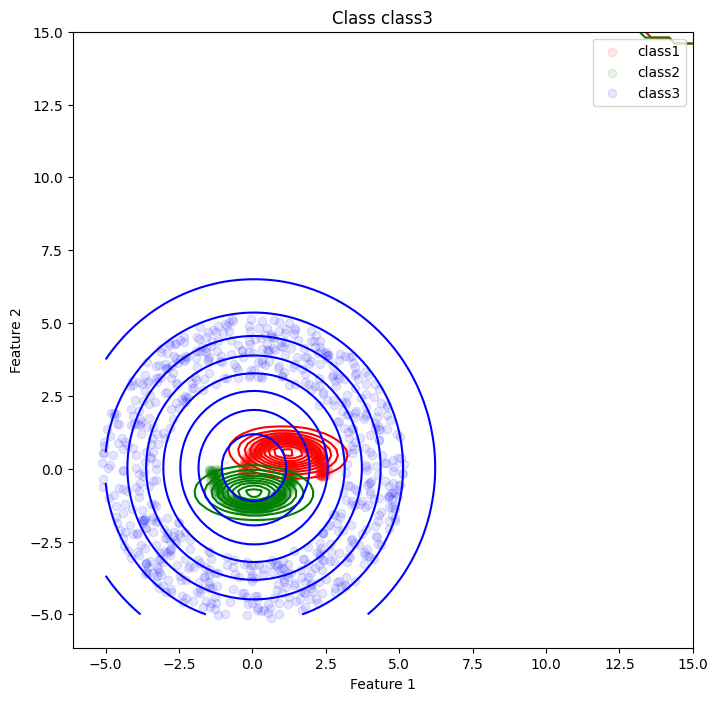

In [62]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_contours(means, cov_matrix, ax, label, color):
    # Create grid and multivariate normal distribution
    x, y = np.meshgrid(np.linspace(-5, 15, 100), np.linspace(-5, 15, 100))
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    rv = multivariate_normal([means[0], means[1]], cov_matrix)

    # Plot contour
    ax.contour(x, y, rv.pdf(pos), levels=10, colors=color)
    ax.set_title(f'Class {label}')

df_class_train = {
    'class1': df1_train,
    'class2': df2_train,
    'class3': df3_train
}

fig, ax = plt.subplots(figsize=(8, 8))

# Plot contours and training data for each class
colors = ['red', 'green', 'blue']
labels = ['class1', 'class2', 'class3']

# Superimpose the training data for each class
for i, label in enumerate(labels):
    means, cov_matrix = class_stats[label]
    plot_contours(means, cov_matrix, ax, label, colors[i])

    # Assuming df_class_train holds training data for each class
    ax.scatter(df_class_train[label][0], df_class_train[label][1], label=label, alpha=0.1, c=colors[i])

# Final plot adjustments
ax.legend()
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

Covariance matrix is diagonal and different

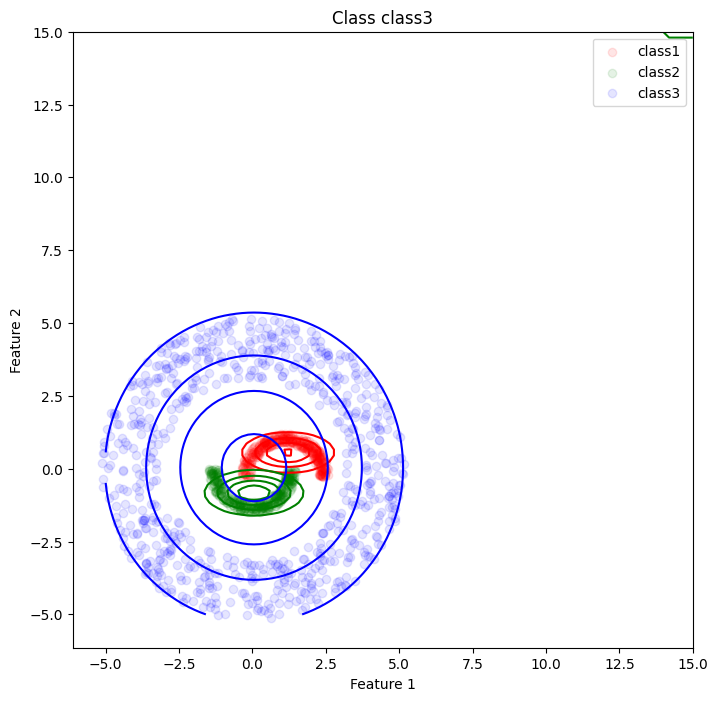

In [49]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_contours(means, cov_matrix, ax, label, color):
    # Create grid and multivariate normal distribution
    x, y = np.meshgrid(np.linspace(-5, 15, 100), np.linspace(-5, 15, 100))
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    rv = multivariate_normal([means[0], means[1]], cov_matrix)

    # Plot contour
    ax.contour(x, y, rv.pdf(pos), levels=4, colors=color)
    ax.set_title(f'Class {label}')

df_class_train = {
    'class1': df1_train,
    'class2': df2_train,
    'class3': df3_train
}

fig, ax = plt.subplots(figsize=(8, 8))

# Plot contours and training data for each class
colors = ['red', 'green', 'blue']
labels = ['class1', 'class2', 'class3']

# Superimpose the training data for each class
for i, label in enumerate(labels):
    means, cov_matrix = class_stats_d[label]
    plot_contours(means, cov_matrix, ax, label, colors[i])

    # Assuming df_class_train holds training data for each class
    ax.scatter(df_class_train[label][0], df_class_train[label][1], label=label, alpha=0.1, c=colors[i])

# Final plot adjustments
ax.legend()
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

Covariance matrix is full but same

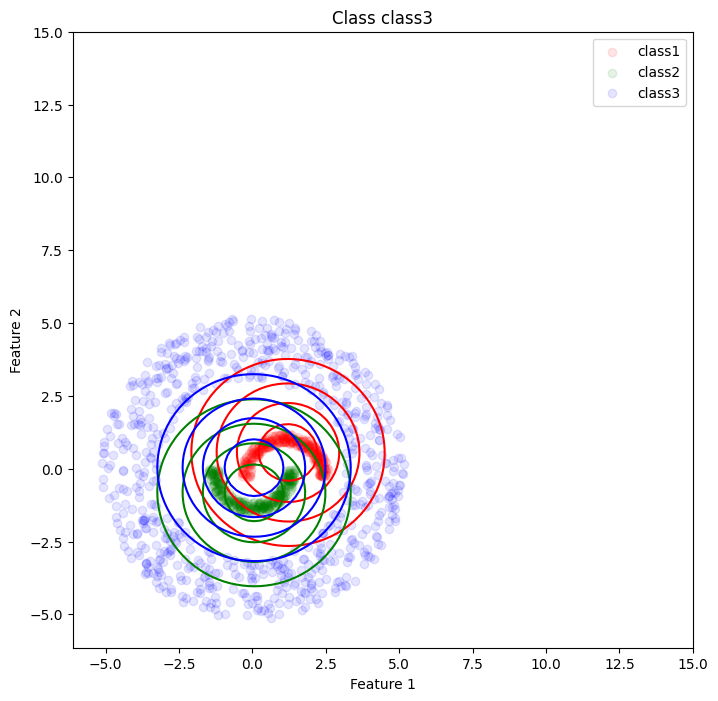

In [50]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_contours(means, cov_matrix, ax, label, color):
    # Create grid and multivariate normal distribution
    x, y = np.meshgrid(np.linspace(-5, 15, 100), np.linspace(-5, 15, 100))
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    rv = multivariate_normal([means[0], means[1]], cov_matrix)

    # Plot contour
    ax.contour(x, y, rv.pdf(pos), levels=4, colors=color)
    ax.set_title(f'Class {label}')

df_class_train = {
    'class1': df1_train,
    'class2': df2_train,
    'class3': df3_train
}

fig, ax = plt.subplots(figsize=(8, 8))

# Plot contours and training data for each class
colors = ['red', 'green', 'blue']
labels = ['class1', 'class2', 'class3']

# Superimpose the training data for each class
for i, label in enumerate(labels):
    means, cov_matrix = class_stats_all[label]
    plot_contours(means, cov_matrix, ax, label, colors[i])

    # Assuming df_class_train holds training data for each class
    ax.scatter(df_class_train[label][0], df_class_train[label][1], label=label, alpha=0.1, c=colors[i])

# Final plot adjustments
ax.legend()
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

Covariance matrix is diagonal and same

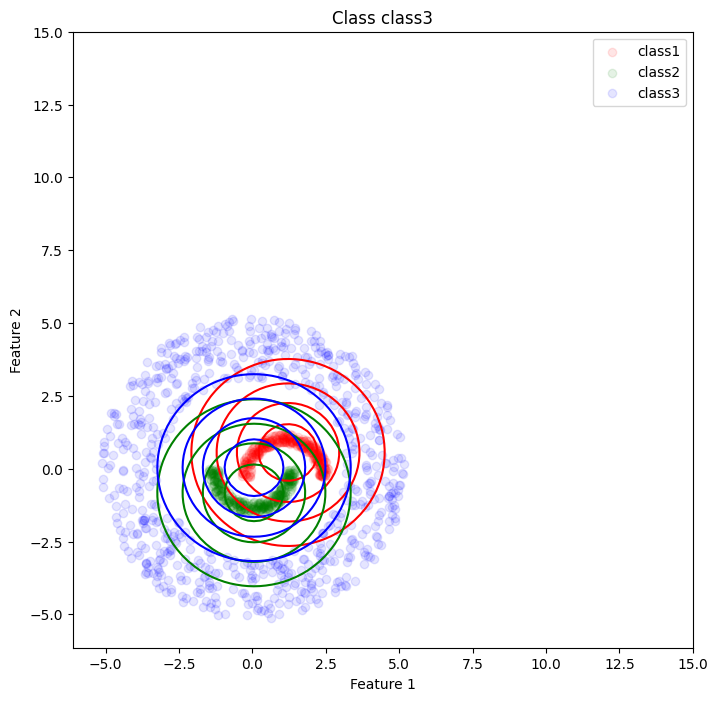

In [51]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_contours(means, cov_matrix, ax, label, color):
    # Create grid and multivariate normal distribution
    x, y = np.meshgrid(np.linspace(-5, 15, 100), np.linspace(-5, 15, 100))
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    rv = multivariate_normal([means[0], means[1]], cov_matrix)

    # Plot contour
    ax.contour(x, y, rv.pdf(pos), levels=4, colors=color)
    ax.set_title(f'Class {label}')

df_class_train = {
    'class1': df1_train,
    'class2': df2_train,
    'class3': df3_train
}

fig, ax = plt.subplots(figsize=(8, 8))

# Plot contours and training data for each class
colors = ['red', 'green', 'blue']
labels = ['class1', 'class2', 'class3']

# Superimpose the training data for each class
for i, label in enumerate(labels):
    means, cov_matrix = class_stats_all_d[label]
    plot_contours(means, cov_matrix, ax, label, colors[i])

    # Assuming df_class_train holds training data for each class
    ax.scatter(df_class_train[label][0], df_class_train[label][1], label=label, alpha=0.1, c=colors[i])

# Final plot adjustments
ax.legend()
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

## DECISION REGION PLOT

Covariance matrix is full and different

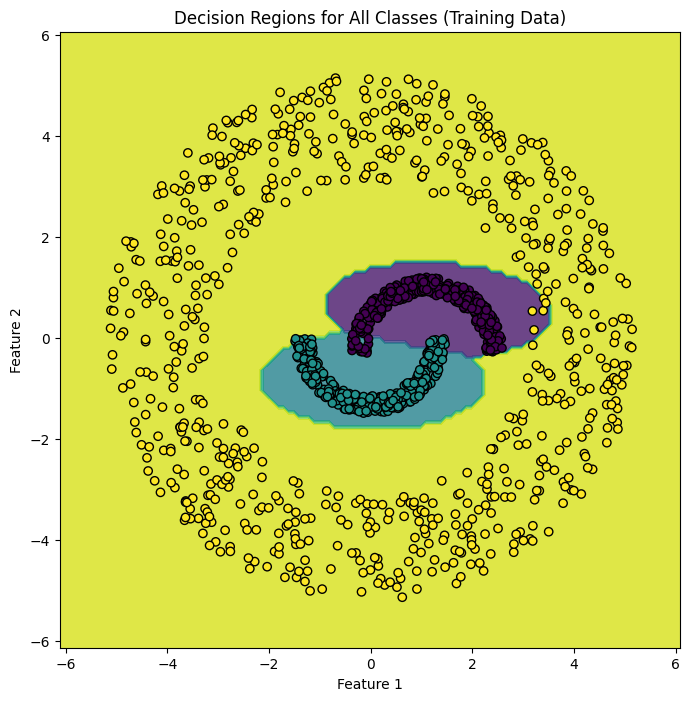

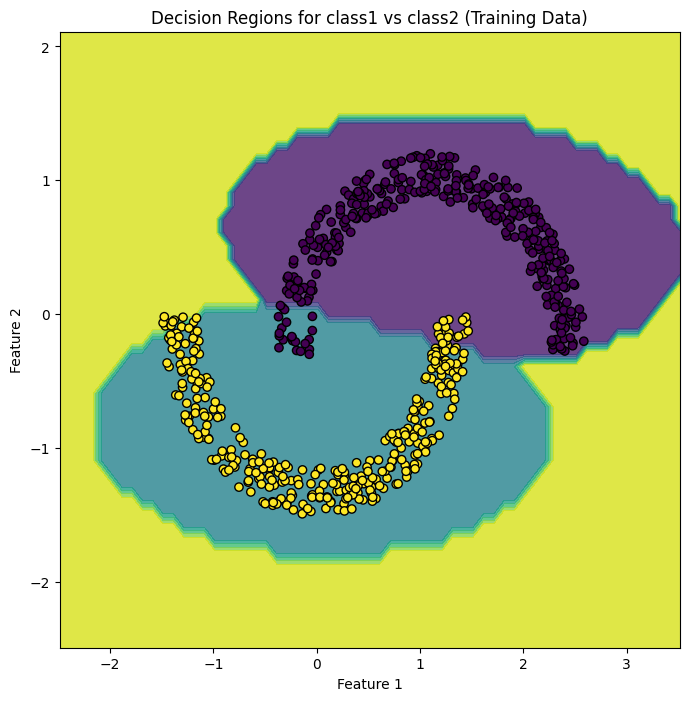

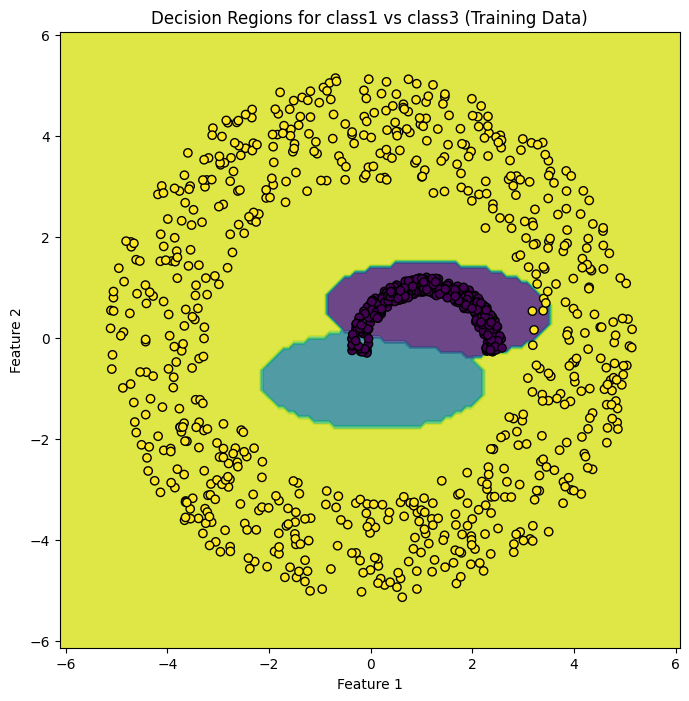

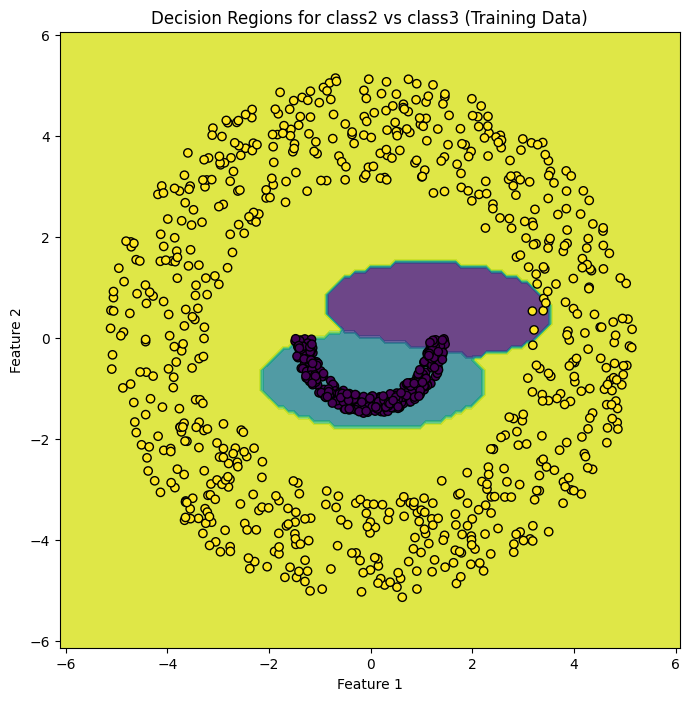

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def predict_class(x_test, class_stats, priors):
    posteriors = calculate_posterior(x_test, class_stats, priors)
    return max(posteriors, key=posteriors.get)

def create_meshgrid(df, step_size=0.1):
    x_min, x_max = df[0].min() - 1, df[0].max() + 1
    y_min, y_max = df[1].min() - 1, df[1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
    return xx, yy

# Combine training data for all classes
df_train_all = pd.concat([df1_train, df2_train, df3_train], ignore_index=True)
df_train_all['class'] = ''
df_train_all.iloc[:len(df1_train), df_train_all.columns.get_loc('class')] = 'class1'
df_train_all.iloc[len(df1_train):len(df1_train)+len(df2_train), df_train_all.columns.get_loc('class')] = 'class2'
df_train_all.iloc[len(df1_train)+len(df2_train):, df_train_all.columns.get_loc('class')] = 'class3'

# Plot decision regions for all classes together
xx, yy = create_meshgrid(df_train_all)
class_mapping = {'class1': 0, 'class2': 1, 'class3': 2}
Z = np.array([predict_class([x, y], class_stats, priors) for x, y in zip(xx.ravel(), yy.ravel())])
Z = np.array([class_mapping[val] for val in Z.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(df_train_all[0], df_train_all[1], c=df_train_all['class'].map({'class1': 0, 'class2': 1, 'class3': 2}), edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Regions for All Classes (Training Data)')
plt.show()

# Plot decision regions for each pair of classes
class_pairs = [('class1', 'class2'), ('class1', 'class3'), ('class2', 'class3')]
for pair in class_pairs:
    class1, class2 = pair
    df_pair = df_train_all[df_train_all['class'].isin(pair)]
    xx, yy = create_meshgrid(df_pair)
    Z = np.array([predict_class([x, y], class_stats, priors) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = np.array([class_mapping[val] for val in Z.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(df_pair[0], df_pair[1], c=df_pair['class'].map({class1: 0, class2: 1}), edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Regions for {class1} vs {class2} (Training Data)')
    plt.show()

Covariance matrix is diagonal and different

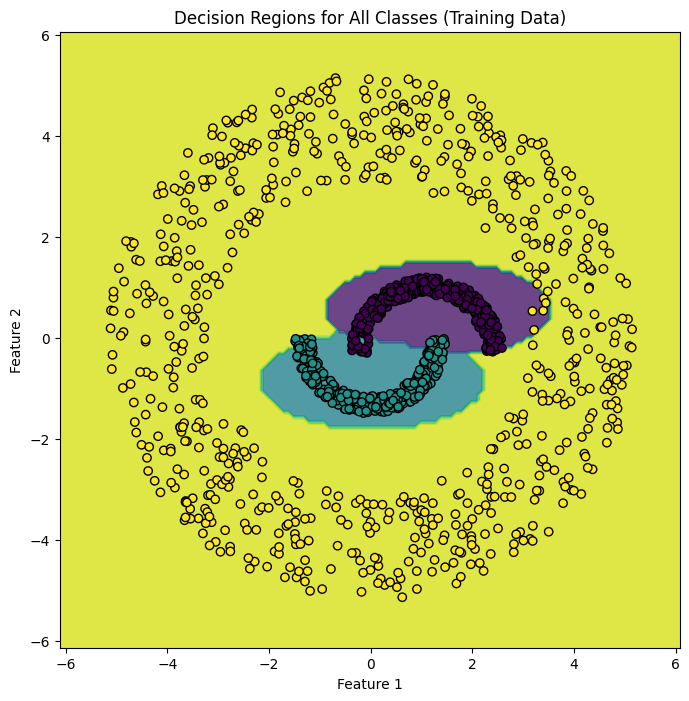

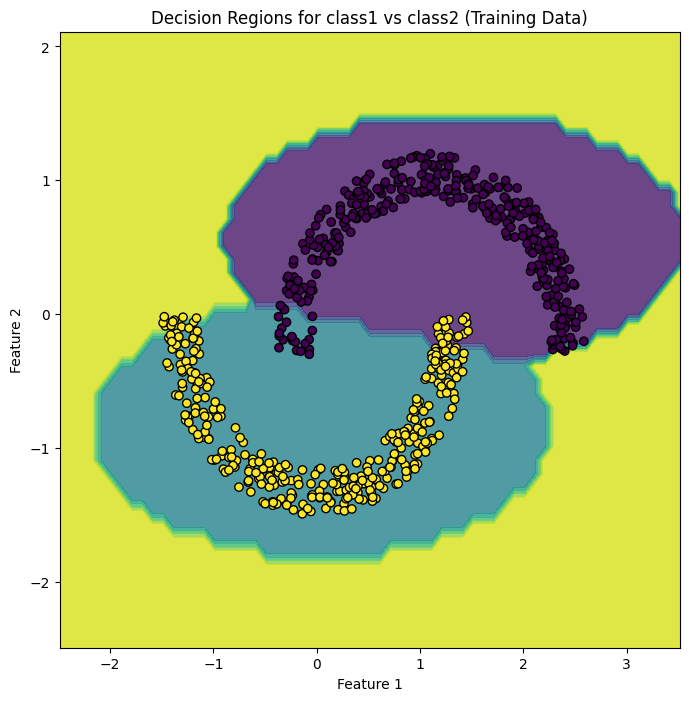

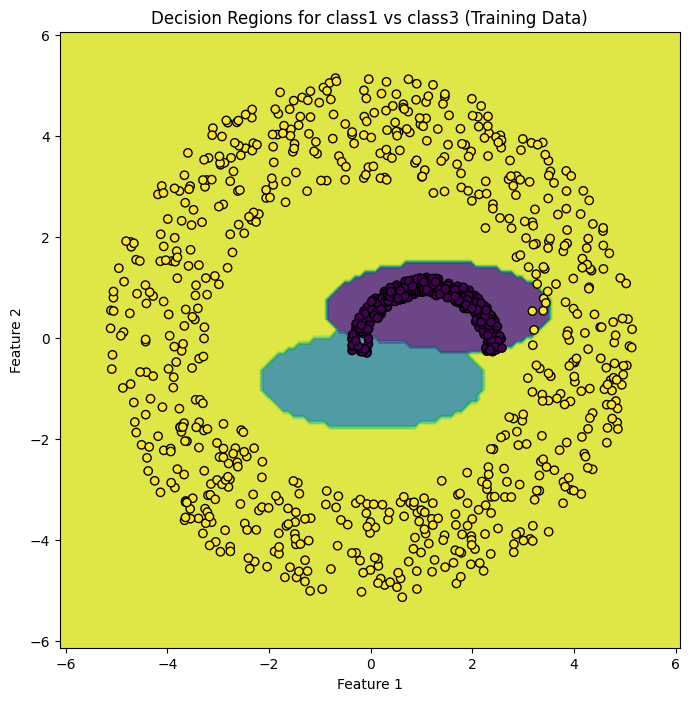

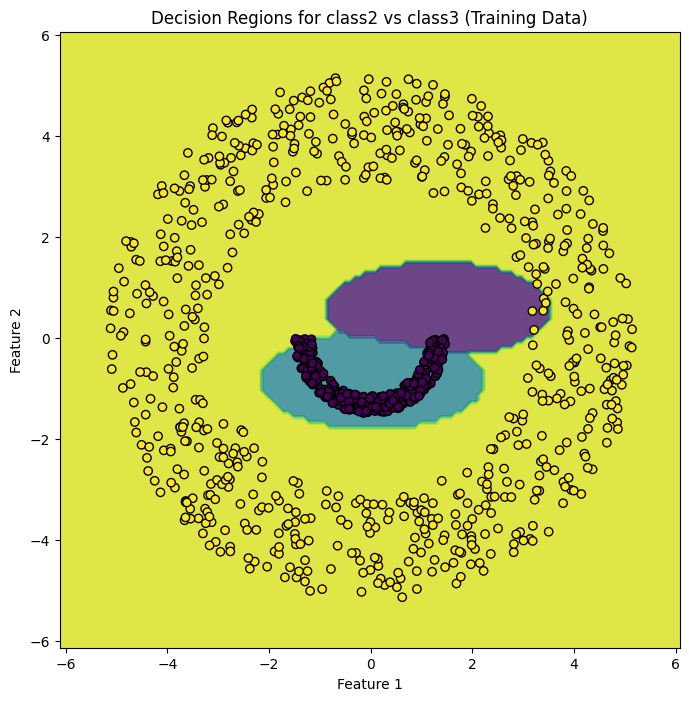

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def predict_class(x_test, class_stats, priors):
    posteriors = calculate_posterior(x_test, class_stats, priors)
    return max(posteriors, key=posteriors.get)

def create_meshgrid(df, step_size=0.1):
    x_min, x_max = df[0].min() - 1, df[0].max() + 1
    y_min, y_max = df[1].min() - 1, df[1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
    return xx, yy

# Combine training data for all classes
df_train_all = pd.concat([df1_train, df2_train, df3_train], ignore_index=True)
df_train_all['class'] = ''
df_train_all.iloc[:len(df1_train), df_train_all.columns.get_loc('class')] = 'class1'
df_train_all.iloc[len(df1_train):len(df1_train)+len(df2_train), df_train_all.columns.get_loc('class')] = 'class2'
df_train_all.iloc[len(df1_train)+len(df2_train):, df_train_all.columns.get_loc('class')] = 'class3'

# Plot decision regions for all classes together
xx, yy = create_meshgrid(df_train_all)
class_mapping = {'class1': 0, 'class2': 1, 'class3': 2}
Z = np.array([predict_class([x, y], class_stats_d, priors) for x, y in zip(xx.ravel(), yy.ravel())])
Z = np.array([class_mapping[val] for val in Z.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(df_train_all[0], df_train_all[1], c=df_train_all['class'].map({'class1': 0, 'class2': 1, 'class3': 2}), edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Regions for All Classes (Training Data)')
plt.show()

# Plot decision regions for each pair of classes
class_pairs = [('class1', 'class2'), ('class1', 'class3'), ('class2', 'class3')]
for pair in class_pairs:
    class1, class2 = pair
    df_pair = df_train_all[df_train_all['class'].isin(pair)]
    xx, yy = create_meshgrid(df_pair)
    Z = np.array([predict_class([x, y], class_stats_d, priors) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = np.array([class_mapping[val] for val in Z.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(df_pair[0], df_pair[1], c=df_pair['class'].map({class1: 0, class2: 1}), edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Regions for {class1} vs {class2} (Training Data)')
    plt.show()

Covariance matrix is full but same

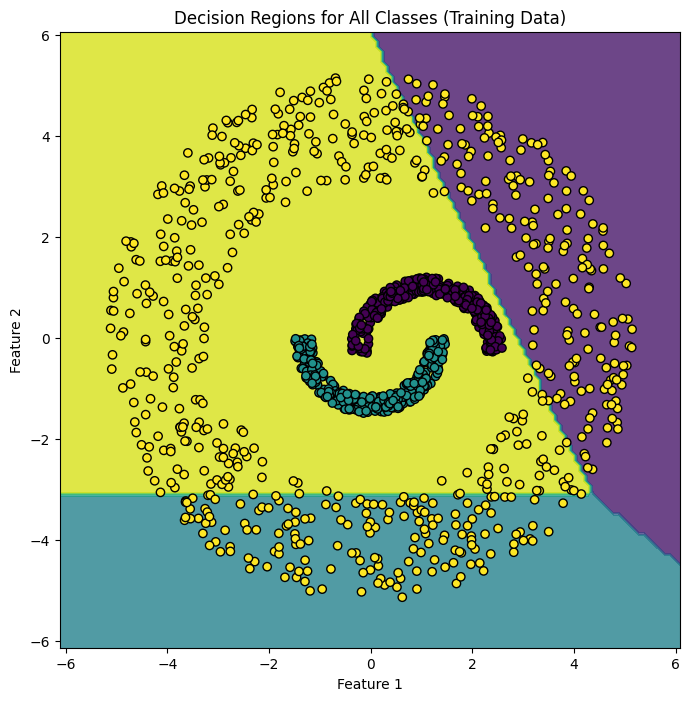

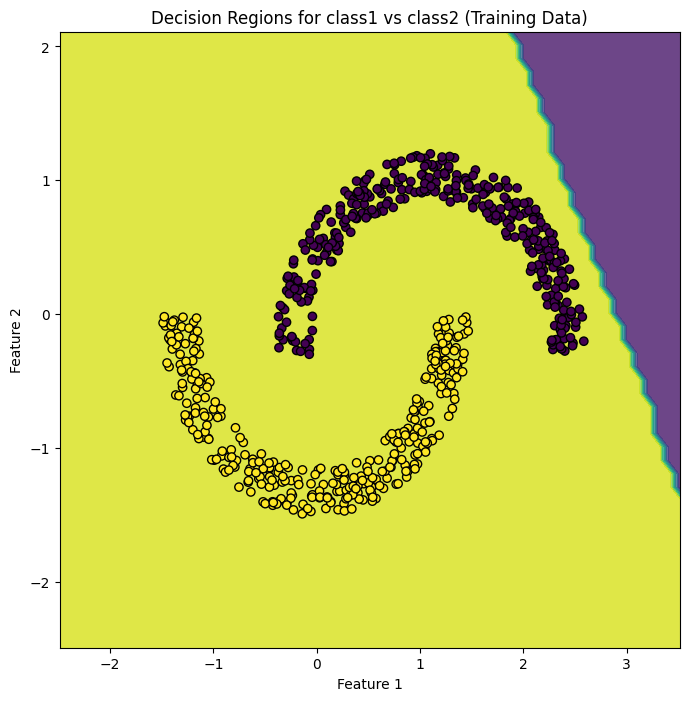

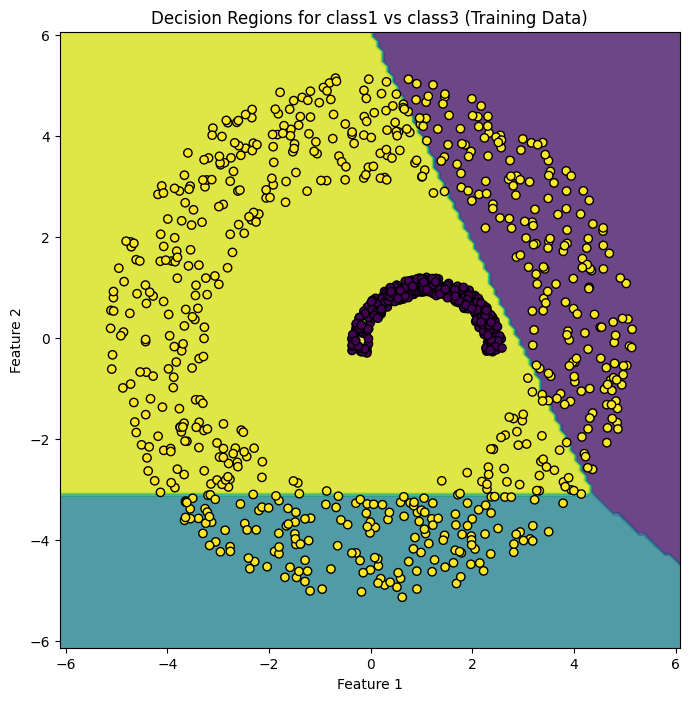

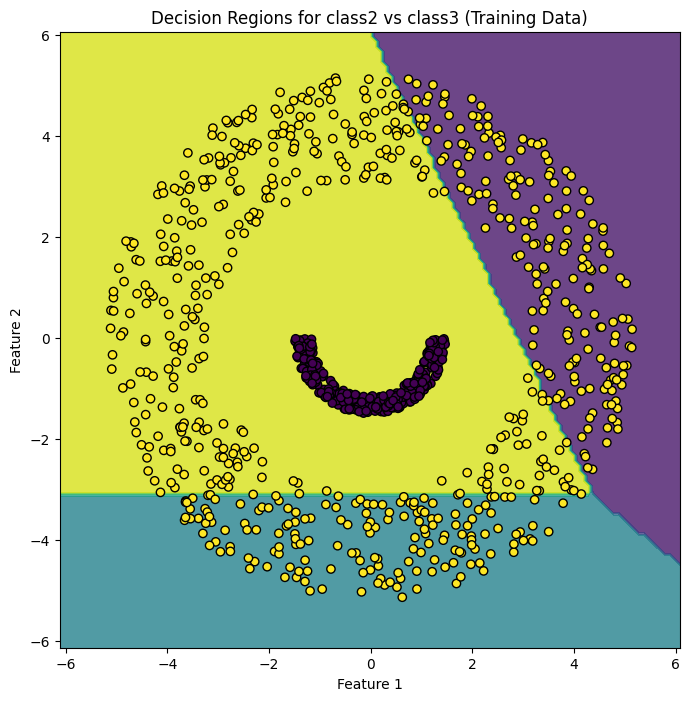

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def predict_class(x_test, class_stats, priors):
    posteriors = calculate_posterior(x_test, class_stats, priors)
    return max(posteriors, key=posteriors.get)

def create_meshgrid(df, step_size=0.1):
    x_min, x_max = df[0].min() - 1, df[0].max() + 1
    y_min, y_max = df[1].min() - 1, df[1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
    return xx, yy

# Combine training data for all classes
df_train_all = pd.concat([df1_train, df2_train, df3_train], ignore_index=True)
df_train_all['class'] = ''
df_train_all.iloc[:len(df1_train), df_train_all.columns.get_loc('class')] = 'class1'
df_train_all.iloc[len(df1_train):len(df1_train)+len(df2_train), df_train_all.columns.get_loc('class')] = 'class2'
df_train_all.iloc[len(df1_train)+len(df2_train):, df_train_all.columns.get_loc('class')] = 'class3'

# Plot decision regions for all classes together
xx, yy = create_meshgrid(df_train_all)
class_mapping = {'class1': 0, 'class2': 1, 'class3': 2}
Z = np.array([predict_class([x, y], class_stats_all, priors) for x, y in zip(xx.ravel(), yy.ravel())])
Z = np.array([class_mapping[val] for val in Z.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(df_train_all[0], df_train_all[1], c=df_train_all['class'].map({'class1': 0, 'class2': 1, 'class3': 2}), edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Regions for All Classes (Training Data)')
plt.show()

# Plot decision regions for each pair of classes
class_pairs = [('class1', 'class2'), ('class1', 'class3'), ('class2', 'class3')]
for pair in class_pairs:
    class1, class2 = pair
    df_pair = df_train_all[df_train_all['class'].isin(pair)]
    xx, yy = create_meshgrid(df_pair)
    Z = np.array([predict_class([x, y], class_stats_all, priors) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = np.array([class_mapping[val] for val in Z.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(df_pair[0], df_pair[1], c=df_pair['class'].map({class1: 0, class2: 1}), edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Regions for {class1} vs {class2} (Training Data)')
    plt.show()

Covariance matrix is diagonal and same

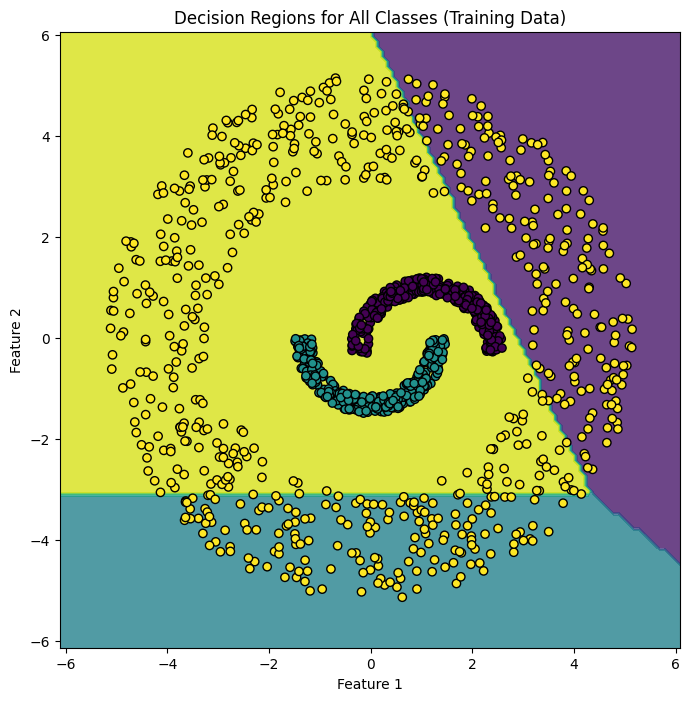

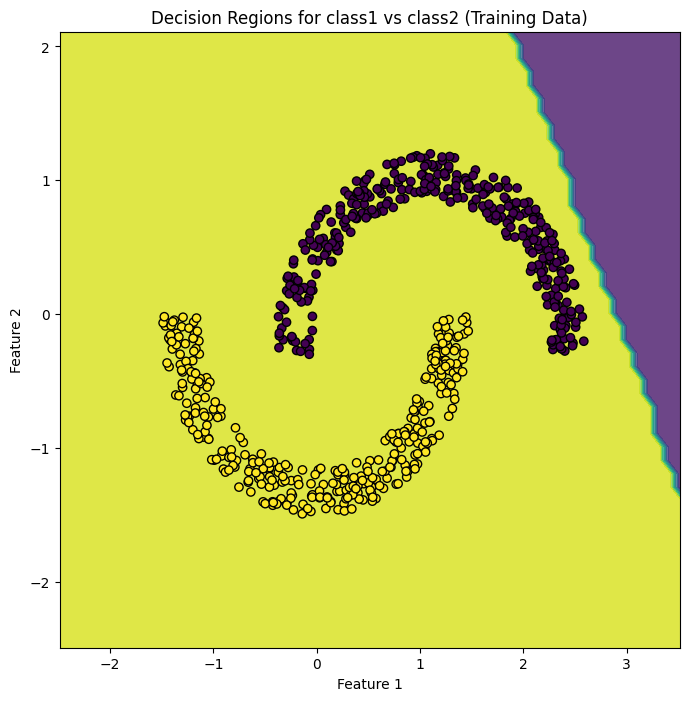

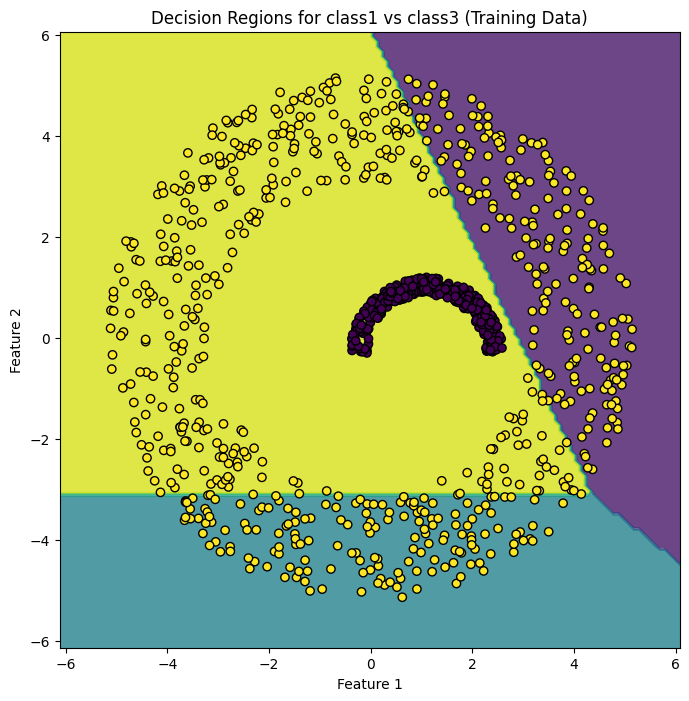

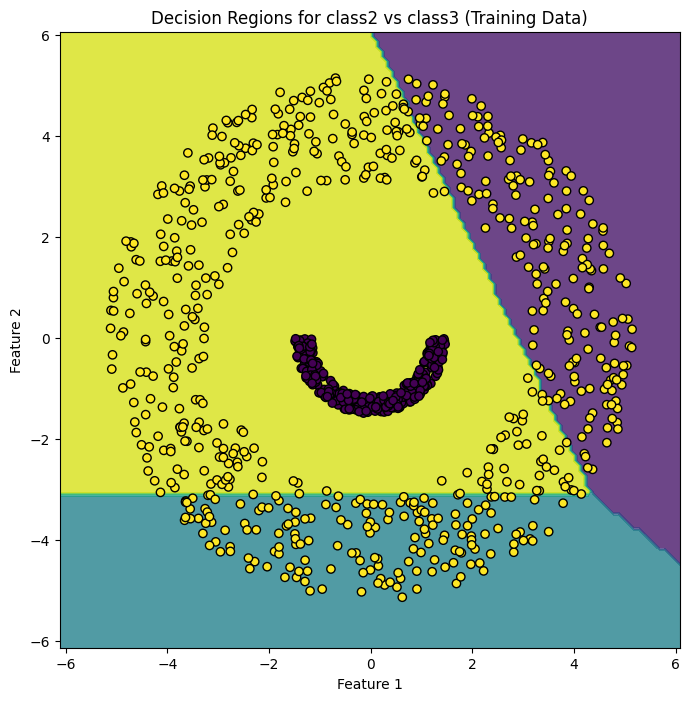

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def predict_class(x_test, class_stats, priors):
    posteriors = calculate_posterior(x_test, class_stats, priors)
    return max(posteriors, key=posteriors.get)

def create_meshgrid(df, step_size=0.1):
    x_min, x_max = df[0].min() - 1, df[0].max() + 1
    y_min, y_max = df[1].min() - 1, df[1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
    return xx, yy

# Combine training data for all classes
df_train_all = pd.concat([df1_train, df2_train, df3_train], ignore_index=True)
df_train_all['class'] = ''
df_train_all.iloc[:len(df1_train), df_train_all.columns.get_loc('class')] = 'class1'
df_train_all.iloc[len(df1_train):len(df1_train)+len(df2_train), df_train_all.columns.get_loc('class')] = 'class2'
df_train_all.iloc[len(df1_train)+len(df2_train):, df_train_all.columns.get_loc('class')] = 'class3'

# Plot decision regions for all classes together
xx, yy = create_meshgrid(df_train_all)
class_mapping = {'class1': 0, 'class2': 1, 'class3': 2}
Z = np.array([predict_class([x, y], class_stats_all_d, priors) for x, y in zip(xx.ravel(), yy.ravel())])
Z = np.array([class_mapping[val] for val in Z.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(df_train_all[0], df_train_all[1], c=df_train_all['class'].map({'class1': 0, 'class2': 1, 'class3': 2}), edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Regions for All Classes (Training Data)')
plt.show()

# Plot decision regions for each pair of classes
class_pairs = [('class1', 'class2'), ('class1', 'class3'), ('class2', 'class3')]
for pair in class_pairs:
    class1, class2 = pair
    df_pair = df_train_all[df_train_all['class'].isin(pair)]
    xx, yy = create_meshgrid(df_pair)
    Z = np.array([predict_class([x, y], class_stats_all_d, priors) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = np.array([class_mapping[val] for val in Z.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(df_pair[0], df_pair[1], c=df_pair['class'].map({class1: 0, class2: 1}), edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Regions for {class1} vs {class2} (Training Data)')
    plt.show()